## Installs and Imports

In [1]:
!pip install transformers
!pip install psycopg2-binary
!pip install torchmetrics

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import tensorflow 
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
import psycopg2
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
from torchmetrics import Accuracy,F1

### Note:
In order to run this notebook, you would need to load the following:
-  'synthetic_testing.parquet" file found in the folder notebooks/datasets
- 'saved_model' folder which is the trained Bert Model

## Load the testing data 

In [3]:
test_df = pd.read_parquet('datasets\synthetic_testing.parquet')
test_df.head()

,tweets,labels
5138,"Tensions in Sweden’s second largest city, Goth...",1
777,"According to preliminary reports, officers Bra...",3
3750,12:54 Report of possible FOUND CHILD at 6XX MT...,0
2051,French police in massive manhunt for rifle-tot...,0
1740,These mass demonstrations were met with violen...,2


## FrankenBert for Predictions

In [4]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification


class FrankenBert:
    """
    Implements BertForSequenceClassification and BertTokenizer
    for binary classification from a saved model
    """

    def __init__(self, path: str):
        """
        If there's a GPU available, tell PyTorch to use the GPU.
        Loads model and tokenizer from saved model directory (path)
        """
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(self.device)

    def predict(self, text: str):
        """
        Makes a binary classification prediction based on saved model
        """
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=280,
            return_tensors='pt',
        ).to(self.device)
        output = self.model(**inputs)
        prediction = output[0].softmax(1)
        tensors = prediction.detach().cpu().numpy()
        result = np.argmax(tensors)
        confidence = tensors[0][result]
        return result

Ensure the path to the model is correct.

In [5]:
model = FrankenBert(r'C:\Users\Bob\Desktop\human-rights-first-police-ds-a\app\saved_model')

In [6]:
test_df.shape


(1504, 2)

In [7]:
test_df.labels.value_counts()

0    535
5    290
1    213
3    179
4    157
2    130
Name: labels, dtype: int64

In [8]:
# Generating predictions using the model
predictions = []
for tweet in test_df.tweets:
    y_pred = model.predict(tweet)
    predictions.append(y_pred)

In [9]:
predictions[:10]

[1, 3, 0, 1, 2, 1, 0, 5, 5, 4]

In [10]:
#Adding the predictions to the testing table
test_df['predictions'] = predictions


In [11]:
test_df.head()

,tweets,labels,predictions
5138,"Tensions in Sweden’s second largest city, Goth...",1,1
777,"According to preliminary reports, officers Bra...",3,3
3750,12:54 Report of possible FOUND CHILD at 6XX MT...,0,0
2051,French police in massive manhunt for rifle-tot...,0,1
1740,These mass demonstrations were met with violen...,2,2


In [12]:
#fixing mis labeled tweets
test_df.at[246, 'labels'] = 4

In [13]:
test_df.at[515, 'labels'] = 5

In [14]:
test_df.at[403, 'labels'] = 4

In [15]:
test_df.at[1028, 'labels'] = 0

In [16]:
test_df.at[725, 'labels'] = 0

In [17]:
test_df.at[735, 'labels'] = 2

In [18]:
test_df.at[5879, 'labels'] = 0

In [19]:
test_df.at[5903, 'labels'] = 0

In [20]:
test_df.at[4855, 'labels'] = 5

In [21]:
test_df.at[5715, 'labels'] = 2

In [22]:
test_df.at[2051, 'labels'] = 1

In [23]:
test_df.at[5884, 'labels'] = 1

In [24]:
test_df.at[109, 'labels'] = 1

In [25]:
test_df.at[4887, 'labels'] = 1

In [26]:
test_df.at[2764, 'labels'] = 1

In [27]:
test_df.at[5514, 'labels'] = 1

In [28]:
test_df.at[4875, 'labels'] = 1

In [29]:
test_df.at[725, 'labels'] = 4

In [30]:
test_df.at[1584, 'labels'] = 1

In [31]:
test_df.at[5622, 'labels'] = 1

In [32]:
test_df.at[2051, 'labels'] = 1

In [33]:
#finding the wrong predictions
gabe = test_df.loc[(test_df['labels'] == 0) & (test_df['predictions']!= 0)]

In [34]:
gabe.head(195)

,tweets,labels,predictions
2363,"According to police, 4-year-old Evan John Wars...",0,5
4009,The Bristol Press - Police apprehend Southingt...,0,1
530,How bad is it? It’s now not safe to use your p...,0,5
2534,Police set up a cordon from West Princes Stree...,0,4
4501,I’m sickened by scenes of people off their hea...,0,2
5281,Why I am not voting for #ScottStringer: 6 mont...,0,5
1028,Ofiara walked into Klein’s Pharmacy with an as...,0,4
5903,"""At least 22 people shot, 2 fatally, after ass...",0,1
85,Here Martwick celebrates a bill that will give...,0,1
3106,"Asian woman, 55, knocked out in unprovoked att...",0,1


In [35]:
#reading the wrong ranked tweets
print(gabe.values)

[['According to police, 4-year-old Evan John Warsecke Jr. climbed up a 7-foot-tall armoire and took a .32-caliber pistol that his father, Traverse City officer Evan Warsecke, had hidden. The gun was reportedly a service pistol, but may have been a backup and not his primary weapon. Evan Jr. apparently took the gun to his bedroom and was playing with it. At around 9:14 p.m., Evan Jr.’s 8-year-old sister heard a noise and and found him injured. His parents were in the basement and didn’t hear the shot, police said. Evan Jr. died the next day at the hospital. His death was ruled an accident.'
  0 5]
 ['The Bristol Press - Police apprehend Southington shooting suspect: https://t.co/ucVFsEQ9Uf'
  0 1]
 ['How bad is it? It’s now not safe to use your phone in public in Chicago. “If you’re thinking of using your phone in a public place, take a look around,” police advised in the alert https://t.co/iGQpkL52CV'
  0 5]
 ['Police set up a cordon from West Princes Street to George Street https://t.

## **Evaluation Metrics:**
 - F1 Score (using sklear and pytorch metrics libraries)
 - Accuracy (using pytorch metrics libraries)
 - Classification Report
 - Confusion Matrix

In [36]:
#Preparing our true values and predicted values
y_true = test_df['labels']
y_pred = test_df['predictions']

In [37]:
#Using sklearn metrics library
f1_score(y_true, y_pred, average='weighted')

0.9774006561286307

In [38]:
#Using Pytorch metrics library

y_pred = torch.tensor(test_df['predictions'].to_list()) 
y_true = torch.tensor(test_df['labels'].to_list())
f1 = F1(num_classes=6)
print("F1 Score using TorchMetrics::",f1(y_pred, y_true))

F1 Score using TorchMetrics:: tensor(0.9774)


In [39]:
#Model Accuracy using Pytorch

metric = Accuracy()
y_pred = torch.tensor(test_df['predictions'].to_list()) 
y_true = torch.tensor(test_df['labels'].to_list())

acc = metric(y_pred, y_true)
print("Test Accuracy using TorchMetrics::",acc)

Test Accuracy using TorchMetrics:: tensor(0.9774)


In [40]:
print(y_true)

tensor([1, 3, 0,  ..., 5, 0, 4])


In [41]:
# Classification Report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

     class 0       0.97      0.98      0.98       529
     class 1       0.95      0.95      0.95       220
     class 2       0.98      0.98      0.98       130
     class 3       0.99      0.99      0.99       175
     class 4       0.98      0.99      0.98       159
     class 5       0.99      0.98      0.98       291

    accuracy                           0.98      1504
   macro avg       0.98      0.98      0.98      1504
weighted avg       0.98      0.98      0.98      1504



<AxesSubplot:>

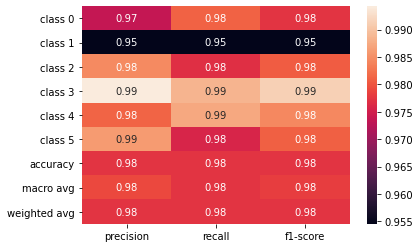

In [42]:
# Classification Report for HeatMap generation

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

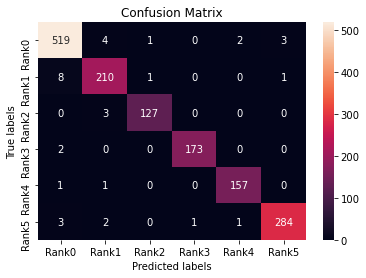

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Rank0', 'Rank1','Rank2','Rank3','Rank4','Rank5']); ax.yaxis.set_ticklabels(['Rank0', 'Rank1','Rank2','Rank3','Rank4','Rank5']);

In [44]:

data = [['Rank 0', 535,523], 
        ['Rank 1', 213,189], 
        ['Rank 2', 130,128],
        ['Rank 3', 179, 176],
        ['Rank 4', 157,156],
        ['Rank 5',290,284]]

accuracy_table = pd.DataFrame(data=data,columns=['Rank','Testcases','True Positives'])


## Conclusions:

Our model is classifying tweets very well with an accuracy of 96.8%. The data below is proof of this.

In [45]:
accuracy_table

,Rank,Testcases,True Positives
0,Rank 0,535,523
1,Rank 1,213,189
2,Rank 2,130,128
3,Rank 3,179,176
4,Rank 4,157,156
5,Rank 5,290,284


In [ ]:
#Just reading in the Tweets
tweetss = test_df['tweets']
tweetss = tweetss.reset_index(drop=True)

In [ ]:
# Lime for Blackbox Explanations 
import lime
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F

tokenizer = BertTokenizer.from_pretrained(r'C:\Users\Bob\Desktop\nonprofit\human-rights-first-police-ds-a\app\saved_model')
model = BertForSequenceClassification.from_pretrained(r'C:\Users\Bob\Desktop\nonprofit\human-rights-first-police-ds-a\app\saved_model')
class_names = target_names

def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    probas = F.softmax(outputs.logits).detach().numpy()
    return probas

explainer = LimeTextExplainer(class_names=class_names)

str_to_predict = tweetss[105]
exp = explainer.explain_instance(str_to_predict, predictor, num_features=10, num_samples=500, top_labels=2)
exp.show_in_notebook(text=str_to_predict)

In [ ]:
tweetss[105]